In [1]:
%matplotlib inline
import numpy
import pandas
from desi_specfinder import SpectrumFinder
from matplotlib import pyplot

searchdata = pandas.DataFrame( [ {'name': 'SN09alu', 'ra': 214.572816, 'dec': 53.788987 },
                                {'name': 'SN09a', 'ra': 215.982879, 'dec': 35.185546 },
                                {'name': 'SN09ac', 'ra': 186.14969, 'dec': 47.237527 } ] )

release = 'daily'
desipasswd = "5kFibers!"  # "putdespasswdhere"

# Build a SpectrumInfo object, passing it the list of ras, decs, and (optionally) names of hosts
si = SpectrumFinder( searchdata['ra'].values, searchdata['dec'].values, names=searchdata['name'].values, radius=1./3600., collection=release, desipasswd=desipasswd )

[2022-06-20 17:39:12,905 - INFO] - Looking for daily spectra at 3 positions w/in 0.0002777777777777778°.)
[2022-06-20 17:39:12,912 - DEBUG] - Search table:
      name          ra        dec
0  SN09alu  214.572816  53.788987
1    SN09a  215.982879  35.185546
2   SN09ac  186.149690  47.237527
[2022-06-20 17:39:12,953 - DEBUG] - Filling temporary table...
[2022-06-20 17:39:12,965 - DEBUG] - ...filled.
[2022-06-20 17:39:12,965 - DEBUG] - Filling second temporary table...
[2022-06-20 17:39:12,971 - DEBUG] - ...filled


In [2]:
# Notice that there are multiple rows where multiple spectra were found.
# The rows where nothing was found are NaN
si._tiledata

filename  \
targetid          tileid petal_loc night                                                         
39633204071631854 20620  9         20220421  daily/tiles/cumulative/20620/20220421/redrock-...   
39633304558764813 174    4         20210405  daily/tiles/cumulative/174/20210405/zbest-4-17...   
                  182    4         20210506  daily/tiles/cumulative/182/20210506/zbest-4-18...   

                                             device_loc  fiber  mean_fiber_ra  \
targetid          tileid petal_loc night                                        
39633204071631854 20620  9         20220421         442   4724     186.149766   
39633304558764813 174    4         20210405         389   2075            NaN   
                  182    4         20210506         476   2416            NaN   

                                             mean_fiber_dec   target_ra  \
targetid          tileid petal_loc night                                  
39633204071631854 20620  9         20220421       47.237488  186.149730   
39633304558764813 174    4         20210405             NaN  214.572828   
                  182    4         20210506             NaN  214.572828   

                                             target_dec         z      zerr  \
targetid          tileid petal_loc night                                      
39633204071631854 20620  9         20220421   47.237511  0.163469  0.000044   
39633304558764813 174    4         20210405   53.788981  0.074413  0.000028   
                  182    4         20210506   53.788981  0.074455  0.000025   

                                             zwarn          chi2    deltachi2  \
targetid          tileid petal_loc night                                        
39633204071631854 20620  9         20220421      0   8468.098463  1641.291418   
39633304558764813 174    4         20210405      0  13555.035346  3268.976829   
                  182    4         20210506      0  11348.816985  5309.306982   

                                            spectype subtype     name  
targetid          tileid petal_loc night                               
39633204071631854 20620  9         20220421   GALAXY           SN09ac  
39633304558764813 174    4         20210405   GALAXY          SN09alu  
                  182    4         20210506   GALAXY          SN09alu

In [3]:
# You can pull out the ones that had observations with notnull():
result[ result.targetid.notnull() ]

NameError: name 'result' is not defined

In [40]:
# You can pull out the ones without observations with isnull()
result[ result.targetid.isnull() ]

,name,ra,dec,targetid,tile,petal,night,z,zerr,zwarn,filename,spectype,subtype
1,SN09a,215.982879,35.185546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
print( f'{len(result[result.targetid.notnull()].groupby("name"))} have spectra' )
print( f'{len(result[result.targetid.isnull()].groupby("name"))} do not' ) 

2 have spectra
1 do not


In [43]:
# DIFFERENT THING

# Get the actual spectrum for the object
survey = release    # daily, everst, fuji, or guadalupe
specinf = SpectrumInfo( data.iloc[0]['ra'], data.iloc[0]['dec'], collection=survey, desipasswd=desipasswd)
print( f"Targets found with spectra: {specinf.targetids}" )

[2022-06-20 15:29:57,138 - INFO] - Looking for daily spectra at (214.5728, 53.7890)


Targets found with spectra: {39633304558764813}


In [44]:
# get the first targetid ; turns out here there are two different spectra
targ = next(iter(specinf.targetids))
print( f'{specinf.info_for_targetid(targ)}' )

[{'z': 0.0744127307916863, 'zerr': 2.75092937715152e-05, 'zwarn': 0, 'deltachi2': 3268.97682878166, 'filename': 'daily/tiles/cumulative/174/20210405/zbest-4-174-thru20210405.fits', 'tileid': 174, 'petal_loc': 4, 'device_loc': 389, 'night': 20210405}, {'z': 0.0744554092356092, 'zerr': 2.53984261047757e-05, 'zwarn': 0, 'deltachi2': 5309.30698201107, 'filename': 'daily/tiles/cumulative/182/20210506/zbest-4-182-thru20210506.fits', 'tileid': 182, 'petal_loc': 4, 'device_loc': 476, 'night': 20210506}]


In [19]:
spectra = specinf.get_spectra( targ )
spectrum = spectra[0]

INFO:spectra.py:291:read_spectra: iotime 0.507 sec to read coadd-4-174-thru20210405.fits at 2022-06-20T15:06:56.107115
INFO:spectra.py:291:read_spectra: iotime 0.443 sec to read coadd-4-182-thru20210506.fits at 2022-06-20T15:06:57.008449


In [33]:
# Put this in the fromat that Alex wants
λ = spectrum.wave['brz']
flux = spectrum.flux['brz'][0]
ivar = spectrum.ivar['brz'][0]
mask = spectrum.mask['brz'][0]

# This is equivalent ot what was in Alex's code
# This is a strange data structure.  A pandas table]
# would make way more sense here.
specdata = numpy.array( [ numpy.log(λ) , flux * λ , ivar/λ**2 , mask ], dtype=object )
#
# This would be just building a single numpy array
# specdata = numpy.empty( ( 4, len(λ) ), dtype=numpy.float64 )
# specdata[ 0, : ] = numpy.log(λ)
# specdata[ 1, : ] = flux * λ
# specdata[ 2, : ] = ivar / λ**2
# specdata[ 3, : ] = mask

In [34]:
spectrum.mask['brz'].shape

(1, 7781)

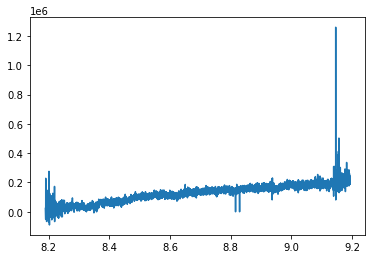

In [35]:
pyplot.plot( specdata[0][:], specdata[1][:] )